Modern Amplitude Estimation (IQAE & MLAE)

We study a simple probability estimation task: a biased coin that outputs “1”
with probability p.

We compare:
- Classical Monte Carlo (MC)
- Error scaling:
$$
\varepsilon_{\text{class}} = O\!\left(\frac{1}{\sqrt{N}}\right)
$$
- Sample complexity:
$$
N_{\text{class}} = O\!\left(\frac{1}{\varepsilon^2}\right)
$$
- Modern Quantum Amplitude Estimation (QAE) algorithms:
- IQAE – Iterative Quantum Amplitude Estimation
- MLAE – Maximum Likelihood Amplitude Estimation

These quantum algorithms:
- Use shallow, hardware-friendly circuits (no large QFT),
- Achieve superior asymptotic scaling:
$$
\varepsilon_{\text{quant}} = O\!\left(\frac{1}{N}\right)
\quad\Rightarrow\quad
N_{\text{quant}} = O\!\left(\frac{1}{\varepsilon}\right)
$$
- This gives a quadratic quantum speedup in sample complexity.

⸻

As accuracy improves, a quantum amplitude estimation algorithm (IQAE / MLAE) needs dramatically fewer oracle calls than classical Monte Carlo.

Classical: $$ N \sim 1/\varepsilon^2 $$
Quantum: $$ N \sim 1/\varepsilon $$

This gap grows rapidly with smaller $$ \varepsilon$$  highlighting the potential for real quantum advantage.

In this notebook we:
1.	Choose a true probability $$ p_{\text{true}}$$
2.	Estimate p using:
- Classical Monte Carlo,
- IQAE on simulator,
- MLAE on simulator,
- optionally IQAE + MLAE on IBM Quantum hardware.
3.	Compare:
- estimated probabilities,
- runtimes,
- number of samples / oracle queries,
- theoretical scaling: classical $$ 1/\varepsilon^2 $$ vs quantum $$ 1/\varepsilon $$

In [14]:
%matplotlib inline

import time
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    SamplerV2 as RuntimeSampler,
)
from qiskit_algorithms import (
    EstimationProblem,
    IterativeAmplitudeEstimation,
    MaximumLikelihoodAmplitudeEstimation,
)

Classical Monte Carlo

In [2]:
def classical_monte_carlo(p_true: float, n_samples: int = 10_000):
    """
    Classical Monte Carlo estimator for a Bernoulli(p_true) random variable.

    Returns:
        p_est   - Monte Carlo estimate of p
        elapsed - runtime in seconds
    """
    start = time.perf_counter()
    samples = np.random.rand(n_samples) < p_true
    p_est = float(np.mean(samples))
    elapsed = time.perf_counter() - start
    return p_est, elapsed

Amplitude-preparation circuit A

In [3]:
def build_amplitude_circuit(p: float) -> QuantumCircuit:
    """
    Prepare a 1-qubit state:
        |ψ> = sqrt(1-p)|0> + sqrt(p)|1>
    This is our state-preparation operator A for amplitude estimation.
    """
    theta = 2 * np.arcsin(np.sqrt(p))
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    return qc

EstimationProblem builder

In [4]:
def build_estimation_problem(p_true: float) -> EstimationProblem:
    """
    Build an EstimationProblem for amplitude estimation:
    - A = build_amplitude_circuit(p_true)
    - objective_qubits = [0]  (measuring qubit 0 as 'good' outcome |1>)
    """
    A = build_amplitude_circuit(p_true)

    problem = EstimationProblem(
        state_preparation=A,
        objective_qubits=[0],
    )
    return problem

IQAE on simulator

In [ ]:
def run_iqae_sim(p_true: float, epsilon: float = 0.02, alpha: float = 0.05, shots: int = 1000):
    """
    Run Iterative Quantum Amplitude Estimation (IQAE) on an ideal Aer sampler.

    Args:
        p_true  - true probability
        epsilon - target additive error
        alpha   - confidence level (1 - alpha)
        shots   - shots per sampler run

    Returns:
        p_est   - estimated probability
        ci      - confidence interval [low, high]
        steps   - approximate #effective oracle queries (from result or ~1/epsilon)
        elapsed - runtime in seconds
    """
    problem = build_estimation_problem(p_true)
    sampler = AerSampler()
    if hasattr(sampler, "options"):
        try:
            sampler.options.shots = shots
        except Exception:
            pass

    iqae = IterativeAmplitudeEstimation(
        epsilon_target=epsilon,
        alpha=alpha,
        sampler=sampler,
    )

    start = time.perf_counter()
    result = iqae.estimate(problem)
    elapsed = time.perf_counter() - start

    p_est = float(result.estimation)
    ci = result.confidence_interval
    steps = getattr(result, "num_oracle_queries", None)
    if steps is None:
        steps = int(1 / epsilon)

    return p_est, ci, steps, elapsed, result

MLAE on simulator

In [6]:
def build_grover_circuit_for_k(p_true: float, k: int) -> QuantumCircuit:
    """
    Build a 1-qubit amplitude amplification circuit that:
      - prepares |ψ> = sqrt(1-p)|0> + sqrt(p)|1>  via A = RY(theta)
      - applies k Grover iterations G = A Z A† Z
      - measures in Z basis.

    This is a tiny, single-qubit version suitable for MLAE-like estimation.
    """
    # Parameter for state |ψ> = Ry(theta)|0>, with sin^2(theta/2) = p
    theta = 2 * np.arcsin(np.sqrt(p_true))

    qc = QuantumCircuit(1)
    # Prepare |ψ> = A|0>
    qc.ry(theta, 0)

    # Grover iteration G = A Z A† Z  (k times)
    for _ in range(k):
        qc.z(0)          # oracle: flip phase of |1>
        qc.ry(-theta, 0) # A†
        qc.z(0)          # reflection about |0>
        qc.ry(theta, 0)  # A

    qc.measure_all()
    return qc

In [7]:
def run_mlae_ibm_manual(p_true: float,
                        ks=(0, 1, 2, 3),
                        shots: int = 1000,
                        user_token: str = None):
    """
    Manual 1-qubit MLAE-style amplitude estimation on an IBM Quantum backend.

    Args:
        p_true     - true probability used to define the Grover operator
        ks         - iterable of Grover powers k (number of iterations)
        shots      - shots per k on the hardware
        user_token - optional IBM Cloud API token (if account not already saved)

    Returns:
        p_hat      - MLE estimate of p from hardware data
        counts_k   - list of (k, counts_dict) for each k
        steps_eff  - rough effective #oracle queries ~ sum(shots * (2k+1))
        elapsed    - wall-clock time in seconds
    """

    if user_token:
        QiskitRuntimeService.save_account(
            channel="ibm_cloud", token=user_token, overwrite=True
        )
    service = QiskitRuntimeService(channel="ibm_cloud")
    print("Connected to IBM Quantum Runtime service.")

    backend = service.least_busy(
        simulator=False,
        min_num_qubits=1,
        operational=True,
    )
    print(f"Using IBM backend: {backend.name}")

    circuits = [build_grover_circuit_for_k(p_true, k) for k in ks]

    # Transpile to backend's ISA
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuits = pm.run(circuits)
    sampler = RuntimeSampler(mode=backend)
    start = time.perf_counter()
    job = sampler.run(isa_circuits, shots=shots)
    result = job.result()
    elapsed = time.perf_counter() - start
    counts_k = []
    for i, k in enumerate(ks):
        pub = result[i]
        try:
            c = pub.data.meas.get_counts()
        except AttributeError:
            bins = list(vars(pub.data).values())
            c = bins[0].get_counts() if bins else {}
        counts_k.append((k, c))

    k_list = []
    n1_list = []
    n_list = []

    for k, counts in counts_k:
        n1 = counts.get("1", 0)
        n0 = counts.get("0", 0)
        k_list.append(k)
        n1_list.append(n1)
        n_list.append(n0 + n1)

    def log_likelihood(p):
        p = np.clip(p, 1e-6, 1 - 1e-6)
        alpha = np.arcsin(np.sqrt(p))  # sin^2(alpha) = p
        logL = 0.0
        for k, n1, n in zip(k_list, n1_list, n_list):
            pk = np.sin((2 * k + 1) * alpha) ** 2
            pk = np.clip(pk, 1e-9, 1 - 1e-9)
            logL += n1 * np.log(pk) + (n - n1) * np.log(1 - pk)
        return logL

    grid = np.linspace(1e-4, 1 - 1e-4, 4000)
    ll_vals = np.array([log_likelihood(p) for p in grid])
    idx_max = int(np.argmax(ll_vals))
    p_hat = float(grid[idx_max])
    steps_eff = int(sum(shots * (2 * k + 1) for k in ks))

    return p_hat, counts_k, steps_eff, elapsed

In [8]:
def run_mlae_sim_manual(p_true: float,
                        ks=(0, 1, 2, 3),
                        shots: int = 1000):
    """
    Manual 1-qubit MLAE-like estimation on Aer simulator.

    Args:
        p_true - true probability used to generate data
        ks     - list of Grover powers k (number of iterations)
        shots  - number of shots per k

    Returns:
        p_hat      - MLE estimate of p
        counts_k   - list of (k, counts_dict) for each k
        steps_eff  - rough effective #oracle calls ~ sum(shots * (2k+1))
        elapsed    - total simulation time
    """
    sim = AerSimulator()
    counts_k = []

    start = time.perf_counter()

    for k in ks:
        qc = build_grover_circuit_for_k(p_true, k)
        tqc = transpile(qc, backend=sim, optimization_level=1)
        job = sim.run(tqc, shots=shots)
        res = job.result()
        counts = res.get_counts()
        counts_k.append((k, counts))
    elapsed = time.perf_counter() - start

    k_list = []
    n1_list = []
    n_list = []

    for k, counts in counts_k:
        n1 = counts.get("1", 0)
        n0 = counts.get("0", 0)
        k_list.append(k)
        n1_list.append(n1)
        n_list.append(n0 + n1)

    def log_likelihood(p):
        p = np.clip(p, 1e-6, 1 - 1e-6)
        alpha = np.arcsin(np.sqrt(p))  # sin^2(alpha) = p
        logL = 0.0
        for k, n1, n in zip(k_list, n1_list, n_list):
            # prob of measuring '1' after k iterations
            pk = np.sin((2 * k + 1) * alpha) ** 2
            pk = np.clip(pk, 1e-9, 1 - 1e-9)
            logL += n1 * np.log(pk) + (n - n1) * np.log(1 - pk)
        return logL

    grid = np.linspace(1e-4, 1 - 1e-4, 4000)
    ll_vals = np.array([log_likelihood(p) for p in grid])
    idx_max = int(np.argmax(ll_vals))
    p_hat = float(grid[idx_max])

    steps_eff = int(sum(shots * (2 * k + 1) for k in ks))

    return p_hat, counts_k, steps_eff, elapsed

IBM Runtime helpers

In [9]:
def get_runtime_service(user_token: str = None) -> QiskitRuntimeService:
    """
    Initialize IBM Quantum Runtime service.

    If user_token is provided, save/use it; otherwise assume account is already saved.
    """
    if user_token:
        QiskitRuntimeService.save_account(
            channel="ibm_cloud",
            token=user_token,
            overwrite=True,
        )
    service = QiskitRuntimeService(channel="ibm_cloud")
    print("Connected to IBM Quantum Runtime service.")
    return service


def choose_ibm_backend(service: QiskitRuntimeService, min_qubits: int = 1):
    """
    Pick a least-busy IBM backend with at least min_qubits.
    """
    backend = service.least_busy(
        simulator=False,
        min_num_qubits=min_qubits,
        operational=True,
    )
    print(f"Using IBM backend: {backend.name}")
    return backend

IQAE & MLAE on IBM backend

In [ ]:
def run_iqae_ibm(p_true: float, epsilon: float = 0.05, alpha: float = 0.1, shots: int = 4000,
                 user_token: str = None):
    """
    Run IQAE on an IBM Quantum backend via Runtime SamplerV2.

    Returns p_est, ci, steps, elapsed, result or (None, None, None, None, None) on failure.
    """
    try:
        service = get_runtime_service(user_token)
        backend = choose_ibm_backend(service, min_qubits=1)
    except Exception as e:
        print("Could not initialize IBM Runtime:", e)
        return None, None, None, None, None

    problem = build_estimation_problem(p_true)

    sampler = RuntimeSampler(mode=backend)

    iqae = IterativeAmplitudeEstimation(
        epsilon_target=epsilon,
        alpha=alpha,
        sampler=sampler,
    )

    start = time.perf_counter()
    try:
        result = iqae.estimate(problem)
    except Exception as e:
        print("Error running IQAE on IBM backend:", e)
        return None, None, None, None, None
    elapsed = time.perf_counter() - start

    p_est = float(result.estimation)
    ci = result.confidence_interval
    steps = getattr(result, "num_oracle_queries", int(1 / epsilon))

    return p_est, ci, steps, elapsed, result


def run_mlae_ibm(p_true: float, shots: int = 4000, user_token: str = None):
    """
    Run MLAE on an IBM Quantum backend via Runtime SamplerV2.

    Returns p_est, ci, steps, elapsed, result or (None, None, None, None, None) on failure.
    """
    try:
        service = get_runtime_service(user_token)
        backend = choose_ibm_backend(service, min_qubits=1)
    except Exception as e:
        print("Could not initialize IBM Runtime:", e)
        return None, None, None, None, None

    problem = build_estimation_problem(p_true)

    sampler = RuntimeSampler(mode=backend)

    mlae = MaximumLikelihoodAmplitudeEstimation(
        sampler=sampler,
    )

    start = time.perf_counter()
    try:
        result = mlae.estimate(problem)
    except Exception as e:
        print("Error running MLAE on IBM backend:", e)
        return None, None, None, None, None
    elapsed = time.perf_counter() - start

    p_est = float(result.estimation)
    ci = getattr(result, "confidence_interval", None)

    steps = shots * 4

    return p_est, ci, steps, elapsed, result

In [ ]:
def quantum_sample_ibm(p_true: float, shots: int = 1000, user_token: str = None):
    """
    Simple QAE-lite sampler on IBM backend using Runtime SamplerV2:

      1. Prepare |ψ> = sqrt(1-p)|0> + sqrt(p)|1>
      2. Measure in Z-basis
      3. Run with Runtime SamplerV2
      4. Return p_est ≈ P(1), runtime, and raw counts

    This does NOT use IQAE internally, it's just basic sampling on hardware.
    """

    if user_token:
        QiskitRuntimeService.save_account(
            channel="ibm_cloud", token=user_token, overwrite=True
        )
    service = QiskitRuntimeService(channel="ibm_cloud")
    print("Connected to IBM Quantum Runtime service.")

    backend = service.least_busy(
        simulator=False,
        min_num_qubits=1,
        operational=True,
    )
    print(f"Using IBM backend: {backend.name}")

    theta = 2 * np.arcsin(np.sqrt(p_true))
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    qc.measure_all()
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit = pm.run(qc)
    sampler = RuntimeSampler(mode=backend)
    start = time.perf_counter()
    job = sampler.run([isa_circuit], shots=shots)
    result = job.result()
    elapsed = time.perf_counter() - start
    pub = result[0]

    try:
        counts = pub.data.meas.get_counts()
    except AttributeError:
        data_bins = list(vars(pub.data).values())
        if not data_bins:
            counts = {}
        else:
            counts = data_bins[0].get_counts()

    n1 = counts.get("1", 0)
    p_est = n1 / shots if shots > 0 else 0.0

    return p_est, elapsed, counts

Interactive experiment (classical + IQAE + MLAE)

In [12]:
def qae_modern_interactive():
    print("=== Modern Amplitude Estimation Challenge (QAE-lite + IQAE + MLAE) ===")

    p_str = input("Enter true probability p_true (e.g., 0.3): ").strip()
    try:
        p_true = float(p_str)
        if not (0.0 < p_true < 1.0):
            raise ValueError
    except ValueError:
        print("Invalid input, using p_true = 0.3.")
        p_true = 0.3

    n_class_str = input("Number of classical samples (default 10000): ").strip()
    try:
        n_class = int(n_class_str) if n_class_str else 10_000
    except ValueError:
        n_class = 10_000

    eps_str = input("Target epsilon for IQAE (default 0.02): ").strip()
    try:
        eps_target = float(eps_str) if eps_str else 0.02
    except ValueError:
        eps_target = 0.02

    use_ibm_str = input("Also use IBM Quantum (sampling + MLAE)? (y/n): ").strip().lower()
    use_ibm = use_ibm_str == "y"

    ibm_token = None
    if use_ibm:
        ibm_token = input("Enter IBM Quantum API token (leave blank if already saved): ").strip() or None

    print(f"\nTrue p = {p_true:.4f}")
    print(f"Classical samples = {n_class}, IQAE target ε = {eps_target:.3f}\n")

    print("[1] Classical Monte Carlo...")
    p_class, t_class = classical_monte_carlo(p_true, n_samples=n_class)
    print(f"    p_est = {p_class:.6f}, time = {t_class:.6f} s, samples = {n_class}")

    print("\n[2] Quantum sampling on simulator (QAE-lite)...")

    def quantum_sample_sim(p, shots=10000):
        theta = 2 * np.arcsin(np.sqrt(p))
        qc = QuantumCircuit(1)
        qc.ry(theta, 0)
        qc.measure_all()

        from qiskit_aer import AerSimulator
        sim = AerSimulator()
        start = time.perf_counter()
        job = sim.run(qc, shots=shots)
        res = job.result()
        counts = res.get_counts()
        elapsed = time.perf_counter() - start

        n1 = counts.get("1", 0)
        p_est = n1 / shots
        return p_est, elapsed, counts

    p_qsim, t_qsim, counts_sim = quantum_sample_sim(p_true, shots=n_class)
    print(f"    p_est = {p_qsim:.6f}, time = {t_qsim:.6f} s, shots = {n_class}")
    print("    Counts (sim):", counts_sim)
    print("\n[3] MLAE on simulator (manual 1-qubit version)...")
    ks_mlae = (0, 1, 2, 3)        # Grover powers
    shots_mlae = 1000             # shots per k
    p_mlae, counts_k_mlae, steps_mlae_eff, t_mlae = run_mlae_sim_manual(
        p_true, ks=ks_mlae, shots=shots_mlae
    )
    print(f"    ks = {ks_mlae}, shots per k = {shots_mlae}")
    print(f"    MLAE sim p_est = {p_mlae:.6f}, time = {t_mlae:.6f} s, "
          f"effective queries ≈ {steps_mlae_eff}")
    print("    Counts per k (sim):")
    for k, c in counts_k_mlae:
        print(f"      k = {k}: {c}")

    p_qibm = None
    t_qibm = None
    p_mlae_ibm = None
    t_mlae_ibm = None
    steps_mlae_ibm = None

    if use_ibm:
        print("\n[4] Quantum sampling on IBM backend (QAE-lite)...")
        p_qibm, t_qibm, counts_ibm = quantum_sample_ibm(
            p_true, shots=n_class, user_token=ibm_token
        )
        print(f"    Q IBM (MC) p_est = {p_qibm:.6f}, time = {t_qibm:.6f} s, shots = {n_class}")
        print("    Counts (IBM):", counts_ibm)

        print("\n[5] MLAE on IBM backend (manual 1-qubit version)...")
        try:
            p_mlae_ibm, counts_k_ibm, steps_mlae_ibm, t_mlae_ibm = run_mlae_ibm_manual(
                p_true, ks=ks_mlae, shots=shots_mlae, user_token=ibm_token
            )
            print(f"    ks = {ks_mlae}, shots per k = {shots_mlae}")
            print(f"    MLAE IBM p_est = {p_mlae_ibm:.6f}, time = {t_mlae_ibm:.6f} s, "
                  f"effective queries ≈ {steps_mlae_ibm}")
            print("    Counts per k (IBM):")
            for k, c in counts_k_ibm:
                print(f"      k = {k}: {c}")
        except Exception as e:
            print("    Error running MLAE on IBM backend:", e)
            p_mlae_ibm = None
            t_mlae_ibm = None
            steps_mlae_ibm = None

    iqae_steps = int(1 / eps_target)  # O(1/ε)

    labels_time = ["Classical", "Quantum sim", "MLAE sim"]
    values_time = [t_class, t_qsim, t_mlae]
    if t_qibm is not None:
        labels_time.append("Quantum IBM")
        values_time.append(t_qibm)
    if t_mlae_ibm is not None:
        labels_time.append("MLAE IBM")
        values_time.append(t_mlae_ibm)

    plt.figure(figsize=(8, 4))
    plt.bar(labels_time, values_time)
    plt.ylabel("Time (seconds)")
    plt.title("Runtime: classical vs quantum sampling vs MLAE (sim / IBM)")
    plt.show()

    classical_steps = n_class
    quantum_steps = n_class

    step_labels = ["Classical samples", "Quantum shots", "MLAE sim queries", "IQAE queries"]
    step_values = [classical_steps, quantum_steps, steps_mlae_eff, iqae_steps]

    if steps_mlae_ibm is not None:
        step_labels.append("MLAE IBM queries")
        step_values.append(steps_mlae_ibm)

    plt.figure(figsize=(9, 4))
    plt.bar(step_labels, step_values)
    plt.ylabel("Number of samples / queries")
    plt.title("Steps: classical MC vs quantum sampling vs MLAE vs IQAE")
    plt.xticks(rotation=15, ha="right")
    plt.tight_layout()
    plt.show()

    epsilons = np.logspace(-3, -1, 50)

    N_classical = 1 / epsilons**2
    N_quantum   = 1 / epsilons   # for IQAE / MLAE

    plt.figure(figsize=(7, 5))
    plt.loglog(epsilons, N_classical, label="Classical MC (1/ε²)")
    plt.loglog(epsilons, N_quantum,   label="IQAE / MLAE (1/ε)")
    plt.xlabel("Target precision ε")
    plt.ylabel("Steps / oracle calls")
    plt.title("Complexity: Classical vs QAE (IQAE / MLAE)")
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

    print("\n=== Summary ===")
    print(f"True p = {p_true:.4f}")
    print(f"Classical:       p_est = {p_class:.4f}, time = {t_class:.6f} s, steps = {classical_steps}")
    print(f"Q sim (MC):      p_est = {p_qsim:.4f}, time = {t_qsim:.6f} s, steps = {quantum_steps}")
    print(f"MLAE sim:        p_est = {p_mlae:.4f}, time = {t_mlae:.6f} s, steps ≈ {steps_mlae_eff}")
    if p_qibm is not None:
        print(f"Q IBM (MC):      p_est = {p_qibm:.4f}, time = {t_qibm:.6f} s, steps = {quantum_steps}")
    if p_mlae_ibm is not None:
        print(f"MLAE IBM:        p_est = {p_mlae_ibm:.4f}, time = {t_mlae_ibm:.6f} s, steps ≈ {steps_mlae_ibm}")
    print(f"IQAE:   target ε = {eps_target:.3f}, effective steps ≈ {iqae_steps} (O(1/ε) vs O(1/ε²))")

=== Modern Amplitude Estimation Challenge (QAE-lite + IQAE + MLAE) ===

True p = 0.3000
Classical samples = 10000, IQAE target ε = 0.020

[1] Classical Monte Carlo...
    p_est = 0.302900, time = 0.000308 s, samples = 10000

[2] Quantum sampling on simulator (QAE-lite)...
    p_est = 0.303500, time = 0.007695 s, shots = 10000
    Counts (sim): {'1': 3035, '0': 6965}

[3] MLAE on simulator (manual 1-qubit version)...
    ks = (0, 1, 2, 3), shots per k = 1000
    MLAE sim p_est = 0.299115, time = 0.249242 s, effective queries ≈ 16000
    Counts per k (sim):
      k = 0: {'1': 296, '0': 704}
      k = 1: {'0': 22, '1': 978}
      k = 2: {'1': 68, '0': 932}
      k = 3: {'0': 359, '1': 641}

[4] Quantum sampling on IBM backend (QAE-lite)...


qiskit_runtime_service.__init__:WARNING:2025-11-17 10:15:48,462: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: new_instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().


Connected to IBM Quantum Runtime service.


qiskit_runtime_service.backends:WARNING:2025-11-17 10:15:49,034: Loading instance: new_instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-17 10:15:50,894: Using instance: new_instance, plan: open


Using IBM backend: ibm_fez
    Q IBM (MC) p_est = 0.301300, time = 9.746285 s, shots = 10000
    Counts (IBM): {'1': 3013, '0': 6987}

[5] MLAE on IBM backend (manual 1-qubit version)...


qiskit_runtime_service.__init__:WARNING:2025-11-17 10:16:03,466: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: new_instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().


Connected to IBM Quantum Runtime service.


qiskit_runtime_service.backends:WARNING:2025-11-17 10:16:03,874: Loading instance: new_instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-17 10:16:05,510: Using instance: new_instance, plan: open


Using IBM backend: ibm_fez
    ks = (0, 1, 2, 3), shots per k = 1000
    MLAE IBM p_est = 0.302865, time = 8.286728 s, effective queries ≈ 16000
    Counts per k (IBM):
      k = 0: {'0': 706, '1': 294}
      k = 1: {'1': 951, '0': 49}
      k = 2: {'0': 941, '1': 59}
      k = 3: {'1': 642, '0': 358}


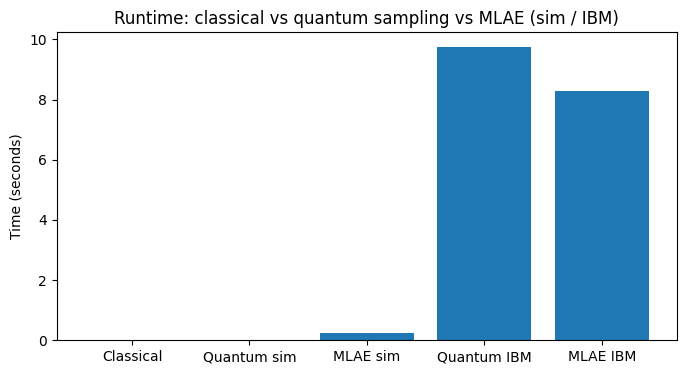

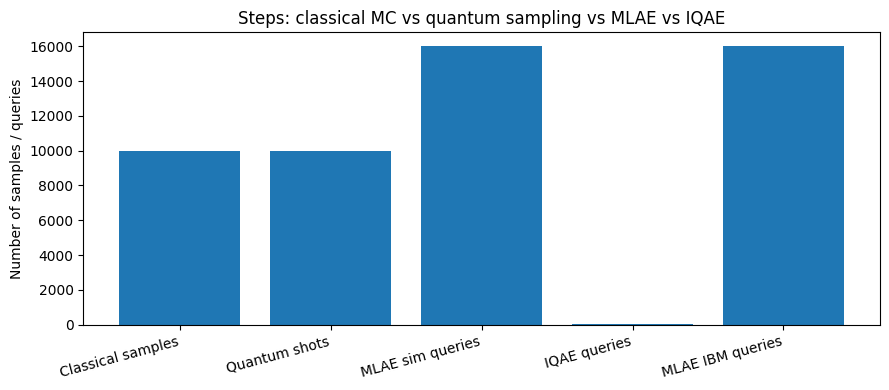

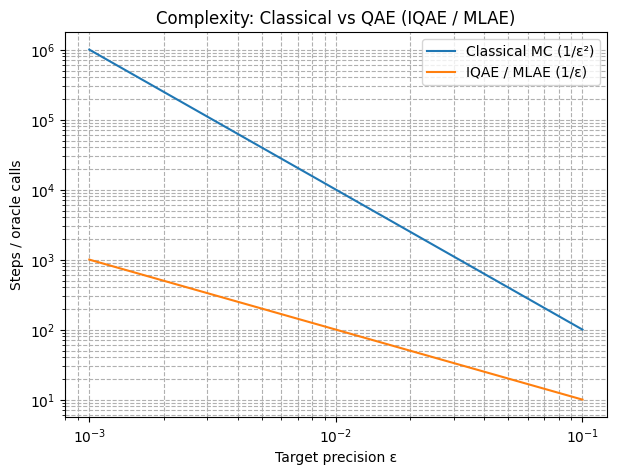


=== Summary ===
True p = 0.3000
Classical:       p_est = 0.3029, time = 0.000308 s, steps = 10000
Q sim (MC):      p_est = 0.3035, time = 0.007695 s, steps = 10000
MLAE sim:        p_est = 0.2991, time = 0.249242 s, steps ≈ 16000
Q IBM (MC):      p_est = 0.3013, time = 9.746285 s, steps = 10000
MLAE IBM:        p_est = 0.3029, time = 8.286728 s, steps ≈ 16000
IQAE:   target ε = 0.020, effective steps ≈ 50 (O(1/ε) vs O(1/ε²))


In [13]:
qae_modern_interactive()